In [388]:
import functools
import tensorflow as tf
tf.test.is_gpu_available() #https://github.com/tensorflow/tensorflow/issues/38194
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd

In [389]:
TRAIN_DATA_PATH = "./data/train.csv"
TEST_DATA_PATH = "./data/test.csv"

train_data = pd.read_csv(TRAIN_DATA_PATH, header=0)
test_data = pd.read_csv(TEST_DATA_PATH, header=0)

In [390]:
test_data['Survived'] = np.nan
# test_data.head()
test_data = test_data[train_data.columns]
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [391]:
data = pd.concat([train_data, test_data], axis=0)

In [392]:
data.describe()
data.info()
data['firstName'] = data['Name'].apply(lambda x: x.split(',')[0].strip())
data['title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
data['lastName'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[1].strip())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [393]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,firstName,title,lastName
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware,Mr,Frederick


In [394]:
label_column = ["Survived"]
id_column = ["PassengerId"]

feature_columns = list(set(data.columns) - set(label_column + id_column))
dense_feature = list(set(data.select_dtypes(include=np.number).columns) & set(feature_columns))
sparse_feature = list(set(data.select_dtypes(exclude=np.number).columns) & set(feature_columns))
sparse_feature

['Sex',
 'Cabin',
 'Name',
 'firstName',
 'title',
 'Embarked',
 'lastName',
 'Ticket']

In [395]:
def process_dense_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna(0.0)  # 暂时填充为0
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    return d
data_dense = process_dense_feats(data, dense_feature)
data_dense

,Parch,Pclass,Fare,Age,SibSp
0,0.000000,1.386294,2.110213,3.135494,0.693147
1,0.000000,0.693147,4.280593,3.663562,0.693147
2,0.000000,1.386294,2.188856,3.295837,0.000000
3,0.000000,0.693147,3.990834,3.583519,0.693147
4,0.000000,1.386294,2.202765,3.583519,0.000000
...,...,...,...,...,...
413,0.000000,1.386294,2.202765,0.000000,0.000000
414,0.000000,0.693147,4.699571,3.688879,0.000000
415,0.000000,1.386294,2.110213,3.676301,0.000000
416,0.000000,1.386294,2.202765,0.000000,0.000000


In [396]:
## 假定数据集是数值类型
# data = data[dense_feature + label_column]

In [397]:
from sklearn.preprocessing import LabelEncoder
def process_sparse_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna("-1")  # 默认填充为-1
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d
data_sparse = process_sparse_feats(data, sparse_feature)
data_sparse

,Sex,Cabin,Name,firstName,title,Embarked,lastName,Ticket
0,1,0,155,100,12,3,855,720
1,0,107,286,182,13,1,601,816
2,0,0,523,329,9,3,690,914
3,0,71,422,267,13,3,541,65
4,1,0,22,15,12,3,1102,649
...,...,...,...,...,...,...,...,...
413,1,0,1126,753,12,3,1119,711
414,0,65,891,593,3,1,366,834
415,1,0,1046,699,12,3,973,872
416,1,0,1227,827,12,3,390,579


In [398]:
total_data = pd.concat([data_dense, data_sparse], axis=1)
total_data['label'] = data[label_column]
total_data['PassengerId'] = data[id_column]
total_data

,Parch,Pclass,Fare,Age,SibSp,Sex,Cabin,Name,firstName,title,Embarked,lastName,Ticket,label,PassengerId
0,0.000000,1.386294,2.110213,3.135494,0.693147,1,0,155,100,12,3,855,720,0.0,1
1,0.000000,0.693147,4.280593,3.663562,0.693147,0,107,286,182,13,1,601,816,1.0,2
2,0.000000,1.386294,2.188856,3.295837,0.000000,0,0,523,329,9,3,690,914,1.0,3
3,0.000000,0.693147,3.990834,3.583519,0.693147,0,71,422,267,13,3,541,65,1.0,4
4,0.000000,1.386294,2.202765,3.583519,0.000000,1,0,22,15,12,3,1102,649,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.000000,1.386294,2.202765,0.000000,0.000000,1,0,1126,753,12,3,1119,711,NaN,1305
414,0.000000,0.693147,4.699571,3.688879,0.000000,0,65,891,593,3,1,366,834,NaN,1306
415,0.000000,1.386294,2.110213,3.676301,0.000000,1,0,1046,699,12,3,973,872,NaN,1307
416,0.000000,1.386294,2.202765,0.000000,0.000000,1,0,1227,827,12,3,390,579,NaN,1308


In [399]:
import tensorflow as tf
dense_inputs = []
for f in dense_feature:
    _input = tf.keras.layers.Input([1], name=f)
    dense_inputs.append(_input)
dense_inputs

[<tf.Tensor 'Parch_6:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Pclass_6:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Fare_6:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Age_6:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'SibSp_6:0' shape=(None, 1) dtype=float32>]

In [400]:
fst_order_dense_layer = tf.keras.layers.Concatenate(axis=1)(dense_inputs)
# fst_order_dense_layer = tf.keras.layers.Dense(100, activation='relu')(concat_dense_inputs)

dense_part = tf.keras.models.Model(dense_inputs, fst_order_dense_layer)

In [401]:
dense_part.summary()



Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Parch (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Pclass (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Fare (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Age (InputLayer)                [(None, 1)]          0                                            
___________________________________________________________________________________________

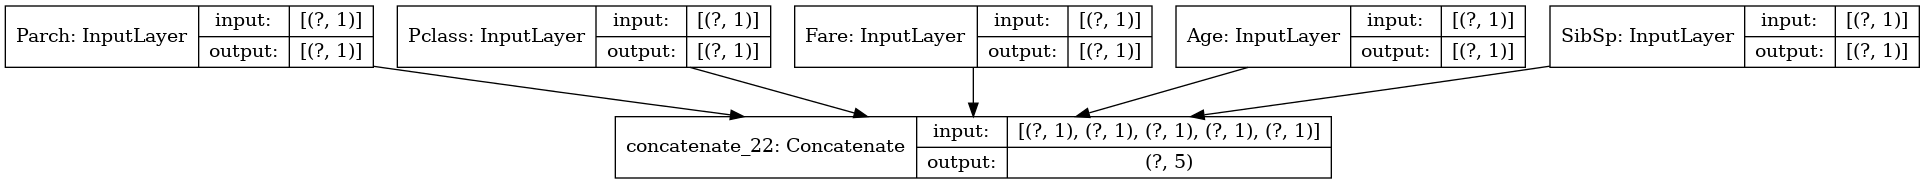

In [402]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(dense_part, "dense_part.png", show_shapes=True)

In [403]:
sparse_inputs = []
for f in sparse_feature:
    _input = tf.keras.layers.Input([1], name=f)
    sparse_inputs.append(_input)
sparse_inputs

import math
import re
sparse_1d_embed = []
for _input in sparse_inputs:
    f = re.split('[_:]', _input.name)[0]
    voc_size = data[f].nunique()
    _embed = tf.keras.layers.Flatten(name=f+"_flatten")(tf.keras.layers.Embedding(voc_size+1, 100, embeddings_regularizer=tf.keras.regularizers.l2(0.5))(_input))
    sparse_1d_embed.append(_embed)
sparse_1d_embed

[<tf.Tensor 'Sex_flatten_10/Identity:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'Cabin_flatten_10/Identity:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'Name_flatten_10/Identity:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'firstName_flatten_2/Identity:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'title_flatten_2/Identity:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'Embarked_flatten_10/Identity:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'lastName_flatten_2/Identity:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'Ticket_flatten_10/Identity:0' shape=(None, 100) dtype=float32>]

In [404]:
fst_order_sparse_layer = tf.keras.layers.Add()(sparse_1d_embed)
sparse_part = tf.keras.models.Model(sparse_inputs, fst_order_sparse_layer) # a + b
sparse_part.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sex (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Cabin (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Name (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
firstName (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

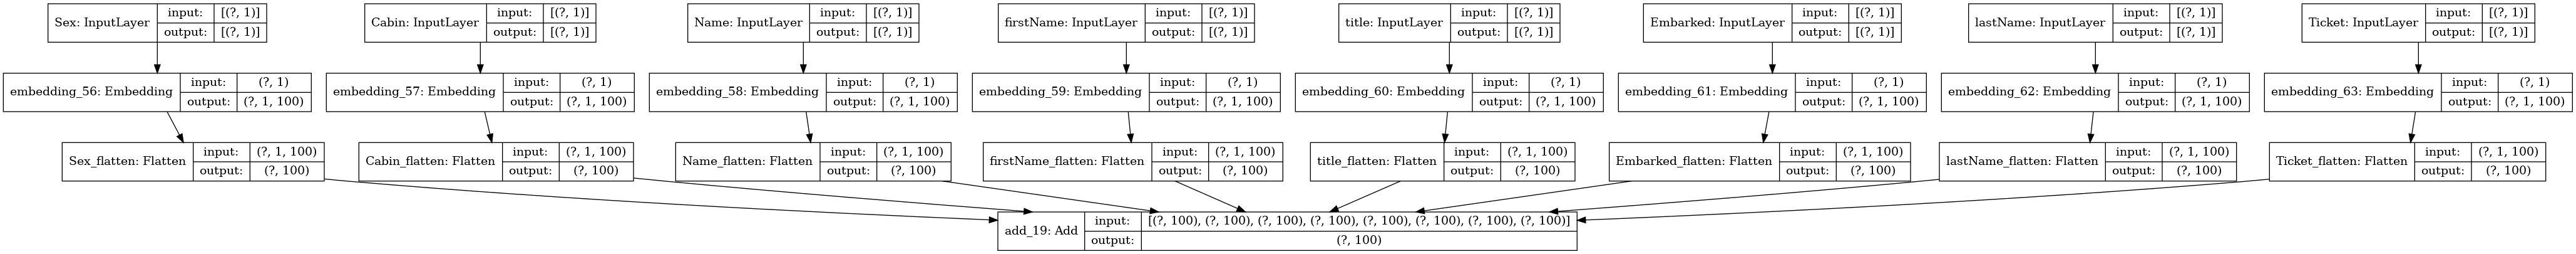

In [405]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(sparse_part, "dense_part.png", show_shapes=True)

In [406]:
from tensorflow.keras.layers import *
linear_part = Concatenate()([fst_order_dense_layer, fst_order_sparse_layer])
# logistic = Activation("sigmoid")(linear_part)
logistic = Dense(1, activation = 'sigmoid')(linear_part)
logistic_regression = tf.keras.models.Model(dense_inputs+sparse_inputs, logistic)

logistic_regression.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sex (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Cabin (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Name (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
firstName (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

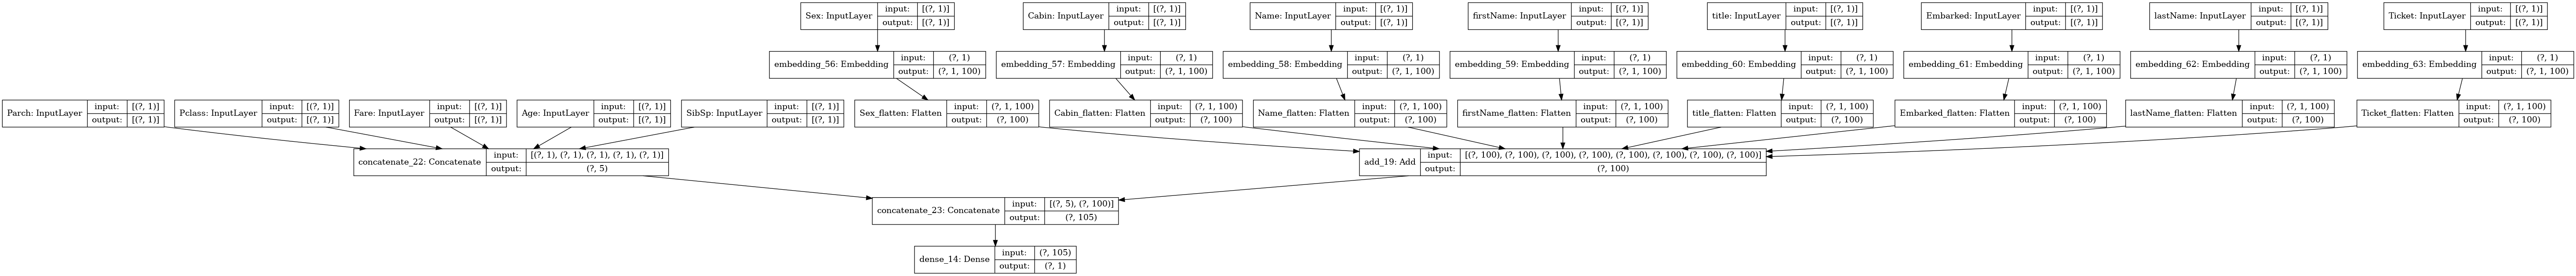

In [407]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
%matplotlib inline
plot_model(logistic_regression, "logistic_regression.png", show_shapes=True)

In [408]:
from tensorflow.keras import optimizers
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(learning_rate=0.003)
logistic_regression.compile(optimizer=adam, 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

In [409]:
from tensorflow.keras.callbacks import TensorBoard

In [410]:
# !rm ./logs -rf
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [411]:
# %whos
# %reset_selective -f tbCallBack 

In [412]:
total_data

,Parch,Pclass,Fare,Age,SibSp,Sex,Cabin,Name,firstName,title,Embarked,lastName,Ticket,label,PassengerId
0,0.000000,1.386294,2.110213,3.135494,0.693147,1,0,155,100,12,3,855,720,0.0,1
1,0.000000,0.693147,4.280593,3.663562,0.693147,0,107,286,182,13,1,601,816,1.0,2
2,0.000000,1.386294,2.188856,3.295837,0.000000,0,0,523,329,9,3,690,914,1.0,3
3,0.000000,0.693147,3.990834,3.583519,0.693147,0,71,422,267,13,3,541,65,1.0,4
4,0.000000,1.386294,2.202765,3.583519,0.000000,1,0,22,15,12,3,1102,649,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.000000,1.386294,2.202765,0.000000,0.000000,1,0,1126,753,12,3,1119,711,NaN,1305
414,0.000000,0.693147,4.699571,3.688879,0.000000,0,65,891,593,3,1,366,834,NaN,1306
415,0.000000,1.386294,2.110213,3.676301,0.000000,1,0,1046,699,12,3,973,872,NaN,1307
416,0.000000,1.386294,2.202765,0.000000,0.000000,1,0,1227,827,12,3,390,579,NaN,1308


In [413]:
test_data = total_data[total_data["label"].isna()]
train_data = total_data[total_data["label"].notna()]

train_data = train_data.loc[:750 - 1] # 闭区间
valid_data = train_data.loc[750:]

train_label = [train_data['label'].values]
train_dense_x = [train_data[f].values for f in dense_feature ]
train_sparse_x = [train_data[f].values for f in sparse_feature ]

val_dense_x = [valid_data[f].values for f in dense_feature]
val_sparse_x = [valid_data[f].values for f in sparse_feature]
val_label = [valid_data['label'].values]

In [415]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=40, min_delta=0.001)
history = logistic_regression.fit(train_dense_x + train_sparse_x, 
          train_label, epochs=200, batch_size=10,
          validation_data=(val_dense_x + val_sparse_x, val_label),  # data is too small
          callbacks=[tbCallBack, es])

Epoch 1/200
56/75 [=====================>........] - ETA: 0s - loss: 0.7352 - binary_crossentropy: 0.5096 - auc: 0.8215

UnboundLocalError: local variable 'logs' referenced before assignment

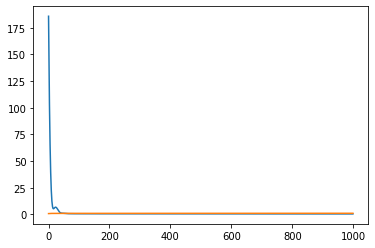

In [377]:
history.history.keys()
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history.get("loss"))
plt.plot(history.epoch, history.history.get("auc"))

In [378]:
test_dense_x = [test_data[f].values for f in dense_feature]
test_sparse_x = [test_data[f].values for f in sparse_feature]
pred = logistic_regression.predict(test_dense_x + test_sparse_x)
# label = np.argmax(pred)
# pred
pred

array([[0.09645909],
       [0.566568  ],
       [0.12694126],
       [0.09174791],
       [0.5806493 ],
       [0.09708458],
       [0.72088575],
       [0.10385877],
       [0.778939  ],
       [0.06476146],
       [0.102025  ],
       [0.22107953],
       [0.9327227 ],
       [0.09536785],
       [0.90363127],
       [0.80910325],
       [0.14088848],
       [0.13423955],
       [0.47270194],
       [0.77402925],
       [0.25022644],
       [0.32923502],
       [0.89910275],
       [0.30074278],
       [0.94759667],
       [0.05324987],
       [0.92267597],
       [0.12271363],
       [0.3663361 ],
       [0.09916532],
       [0.11421192],
       [0.08865231],
       [0.6017178 ],
       [0.52664477],
       [0.370547  ],
       [0.12338173],
       [0.67040014],
       [0.62017083],
       [0.10094455],
       [0.3621657 ],
       [0.12409648],
       [0.37674233],
       [0.10563287],
       [0.7961372 ],
       [0.9429487 ],
       [0.09310281],
       [0.44673395],
       [0.101

In [379]:
# w = train_data[train_data['label'] == 1]["label"].count() / train_data["label"].count()

y_pred = [ 1 if i[0] >= 0.5 else 0 for i in pred ]

In [380]:
y_pred

from pandas.core.frame import DataFrame
c = {"Survived":y_pred #,'b':b
    }  #将列表a，b装换成字典
 
pd_y = DataFrame(c)
print(pd_y)

     Survived
0           0
1           1
2           0
3           0
4           1
..        ...
413         0
414         1
415         0
416         0
417         1

[418 rows x 1 columns]


In [381]:
test_data['PassengerId']

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [382]:
test_data.head()
submission = pd.concat([test_data['PassengerId'], pd_y], axis=1)
submission.to_csv('submission.csv', header=True, index=False)

In [383]:
# ! pip install kaggle
!head submission.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [313]:
!kaggle competitions submit -c titanic -f submission.csv -m "tensorflow lr"

100%|████████████████████████████████████████| 2.77k/2.77k [00:07<00:00, 371B/s]
Successfully submitted to Titanic: Machine Learning from Disaster